# Online Trading Customer Attrition Risk Prediction using SparkML

There are many users of online trading platforms and these companies would like to run analytics on and predict churn based on user activity on the platform. Since competition is rife, keeping customers happy so they do not move their investments elsewhere is key to maintaining profitability.

In this notebook, we will leverage IBM Cloud Pak for Data to do the following:

1. Ingest merged customer demographics and trading activity data
2. Visualize the merged dataset to get a better understanding of the data and build hypotheses for prediction
3. Leverage the SparkML library to build a classification model that predicts whether a customer has a propensity to churn
4. Expose the SparkML classification model as a RESTful API endpoint for the end-to-end customer churn risk prediction and risk remediation application

<a id="top"></a>
## Table of Contents

1. [Load the customer demographics and trading activity data](#load_data)
2. [Load libraries](#load_libraries)
3. [Visualize the customer demographics and trading activity data](#visualize)
4. [Prepare data for building SparkML classification model](#prepare_data)
5. [Train classification model and test model performance](#build_model)
6. [Save and deploy the model using Watson Machine Learning](#save_model)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code (further below). 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_data"></a>
## 1. Load the customer and trading activity data
[Top](#top)

Data can be easily loaded within IBM Cloud Pak for Data using point-and-click functionality. The following image illustrates how to load the data from a database. The data set can be located by its name and inserted into the notebook as a pandas DataFrame as shown below.

![insert_spark_dataframe.png](https://raw.githubusercontent.com/IBM/icp4d-customer-churn-classifier/master/doc/source/images/insert_spark_dataframe.png)

The generated code comes up with a generic name and it is good practice to rename the dataframe to match the use case context.

<h3><font color="RED">ACTION: Import the remote data set in the code cell below.</font></h3>

In [1]:
# Use the find data 01/00 icon and under your remote data set
# use "Insert to code" and "pandas DataFrame"
# to import the input data into the notebook.

# Add asset from file system
import pandas as pd

df_data_1 = pd.read_csv('/project_data/data_asset/mergedcustomers.csv')
df_data_1.head()


,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1703,Medium,M,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,1704,Low,M,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,1705,Low,F,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,1706,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,1707,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [2]:
# After inserting the pandas DataFrame code above, change the following
# df_data_# to match the variable used in the above code. df_churn_pd is used
# later in the notebook.
df_churn_pd = df_data_1

<a id="load_libraries"></a>
## 2. Load libraries
[Top](#top)

Use the commented code in the following cell to load all libraries needed to load, visualize, prepare the data and build ML models for our use case.

<h3><font color="RED">NOTE: if you install any of the required libraries here, you will have to restart the KERNEL and re-run code from the beginning of the notebook.</font></h3>

In [3]:
# The following libraries are required for this notebook and should already be installed in the 
# kernel. If not, install them here. The versions listed have been tested to work with this notebook.

# NOTE: if you do have to perform one or more of these installs, you MUST restart the kernel
#!pip install --user pyspark==2.3.2
#!pip install --user py4j==0.10.7
#!pip install --user ibm-watson-machine-learning==1.0.44
#!pip install --user brunel==2.3

# check if libraries are loaded
!pip freeze

absl-py==0.9.0
aiohttp==3.6.2
asn1crypto==0.24.0
astor==0.8.0
astropy==4.0.1.post1
async-timeout==3.0.1
attrs==19.3.0
autovizwidget==0.13.1
azure-core==1.8.0
azure-cosmos==4.1.0
backcall==0.2.0
beautifulsoup4==4.9.1
biopython @ file:///tmp/build/80754af9/biopython_1593539316417/work
bleach==3.1.5
blinker==1.4
bokeh @ file:///tmp/build/80754af9/bokeh_1593187586470/work
boto3==1.13.11
botocore==1.16.11
brotlipy==0.7.0
brunel==2.3
ca-data-connector @ file:///tmp/ws-build/install/ca-data-connector-python-11.2.0.tgz
cachetools @ file:///tmp/build/80754af9/cachetools_1596822027882/work
cassandra-driver==3.24.0
certifi==2019.3.9
cffi==1.12.2
chardet==3.0.4
chevron==0.13.1
click==7.1.2
cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1594141588948/work
cplex==12.10.0.1
cryptography==2.5
cx-Oracle==7.2.3
cycler==0.10.0
cytoolz==0.10.1
dask @ file:///tmp/build/80754af9/dask-core_1594156306305/work
decorator==4.4.2
defusedxml==0.6.0
dill==0.2.9
docloud==1.0.375
docplex==2.14.186
docutils==0.1

In [4]:
import os
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import brunel

import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
%matplotlib inline

<a id="visualize"></a>
## 3. Visualize the customer demographics and trading activity data
[Top](#top)


Data visualization is a key step in the data mining process that helps to better understand the data before it can be prepared for building ML models. In this notebook, we will use Brunel for data visualization.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki


### Churn risk count

In [5]:
%brunel data('df_churn_pd') stack polar bar x(CHURNRISK) y(#count) color(CHURNRISK) bar tooltip(#all) :: width=300, height=300

<IPython.core.display.Javascript object>

### Marital status count and churn risk percentage

In [6]:
%brunel data('df_churn_pd') bar x(STATUS) y(#count) color(STATUS) tooltip(#all) | stack bar x(STATUS) y(#count) color(CHURNRISK: pink-orange-yellow) bin(STATUS) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

### Churn risk count by total units traded

In [7]:
%brunel data('df_churn_pd') stack bar x(TOTALUNITSTRADED:[0, 350]) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) label(#count) tooltip(#all) :: width=1200, height=350 


<IPython.core.display.Javascript object>

### Churn risk percentage by days since last trade

In [8]:
%brunel data('df_churn_pd') stack bar x(DAYSSINCELASTTRADE) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 


<IPython.core.display.Javascript object>

<a id="prepare_data"></a>
## 4. Prepare data for building SparkML classification model
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes the bulk of data scientists' time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices are encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.

Final step in the data preparation process is to assemble all the categorical and non-categorical columns into a feature vector. We use VectorAssembler for this. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.

In [9]:
# Defining the categorical columns 
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

In [10]:
non_categoricalColumns = [c for c in df_churn_pd.columns if c not in categoricalColumns]

In [ ]:
print(non_categoricalColumns)

In [12]:
non_categoricalColumns.remove('CHURNRISK')

In [13]:
# Create a Spark session
spark = SparkSession.builder.getOrCreate()

In [14]:
stages = []
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    
    stages += [stringIndexer, encoder]

In [15]:
spark_df_churn = spark.createDataFrame(df_churn_pd)
labelIndexer = StringIndexer(inputCol='CHURNRISK', outputCol='label').fit(spark_df_churn)

In [16]:
for colnum in non_categoricalColumns:
    spark_df_churn = spark_df_churn.withColumn(colnum, spark_df_churn[colnum].cast(IntegerType()))

In [17]:
# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + non_categoricalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

<a id="build_model"></a>
## 5. Train classification model and test model performance
[Top](#top)

We instantiate a decision-tree based classification algorithm, namely, RandomForestClassifier. Next we define a pipeline to chain together the various transformers and estimators that were defined during the data preparation step. MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline or workflow.

We split the original dataset into train and test datasets. We fit the pipeline to training data and apply the trained model on the test data and generate churn risk class prediction.

In [18]:
# Instantiate a random forest classifier, take the default settings
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

stages += [labelIndexer, assembler, rf, labelConverter]

pipeline = Pipeline(stages=stages)

In [19]:
# Split data into train and test datasets
train, test = spark_df_churn.randomSplit([0.7,0.3], seed=100)
train.cache()
test.cache()

DataFrame[ID: int, CHURNRISK: string, GENDER: string, STATUS: string, CHILDREN: int, ESTINCOME: int, HOMEOWNER: string, AGE: int, TOTALDOLLARVALUETRADED: int, TOTALUNITSTRADED: int, LARGESTSINGLETRANSACTION: int, SMALLESTSINGLETRANSACTION: int, PERCENTCHANGECALCULATION: int, DAYSSINCELASTLOGIN: int, DAYSSINCELASTTRADE: int, NETREALIZEDGAINS_YTD: int, NETREALIZEDLOSSES_YTD: int]

In [20]:
# Build models
model = pipeline.fit(train)

In [21]:
results = model.transform(test)
results = results.select(results["ID"],results["CHURNRISK"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURNRISK,label,predictedLabel,prediction,probability
0,4,High,0.0,High,0.0,"[0.7751444576377333, 0.0, 0.22485554236226674]"
1,7,High,0.0,High,0.0,"[0.832607478517833, 0.0, 0.16739252148216704]"
2,8,Medium,2.0,Medium,2.0,"[0.35236102575997486, 0.0010206246817178748, 0..."
3,9,Medium,2.0,Medium,2.0,"[0.12105198105034824, 0.013887821744141373, 0...."
4,15,Low,1.0,Low,1.0,"[0.025482625482625483, 0.9377542479124837, 0.0..."
5,18,Low,1.0,Low,1.0,"[0.016417910447761194, 0.9544471814964985, 0.0..."


### Model results

In a supervised classification problem such as churn risk classification, we have a true output and a model-generated predicted output for each data point. For this reason, the results for each data point can be assigned to one of four categories:

1. True Positive (TP) - label is positive and prediction is also positive
2. True Negative (TN) - label is negative and prediction is also negative
3. False Positive (FP) - label is negative but prediction is positive
4. False Negative (FN) - label is positive but prediction is negative

These four numbers are the building blocks for most classifier evaluation metrics. A fundamental point when considering classifier evaluation is that pure accuracy (i.e. was the prediction correct or incorrect) is not generally a good metric. The reason for this is because a dataset may be highly unbalanced. For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.



In [22]:
print('Model Precision = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count())))

Model Precision = 0.94.


An added advantage of such tree-based classifiers is we can study feature importances and learn further about relative importances of features in the classification decision.

In [23]:
# Evaluate model

# Compute raw scores on the test set
res = model.transform(test)
predictions = res.rdd.map(lambda pr: pr.prediction)
labels = res.rdd.map(lambda pr: pr.label)
predictionAndLabels = spark.sparkContext.parallelize(zip(predictions.collect(), labels.collect()))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
print("Overall Statistics")
f_measure = metrics.accuracy
print("Model F-measure = %s\n" % f_measure)

# statistics by class
print("Statistics by Class")
labels_itr = labels.distinct().collect()
for label in sorted(labels_itr):
    print("Class %s F-Measure = %s" % (label, metrics.fMeasure(label)))

Overall Statistics
Model F-measure = 0.9403453689167975

Statistics by Class
Class 0.0 F-Measure = 0.945859872611465
Class 1.0 F-Measure = 0.9906103286384975
Class 2.0 F-Measure = 0.8272727272727274


In [24]:
# Feature importance

rfModel = model.stages[-2]

features = df_churn_pd.columns
importances = rfModel.featureImportances.values
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

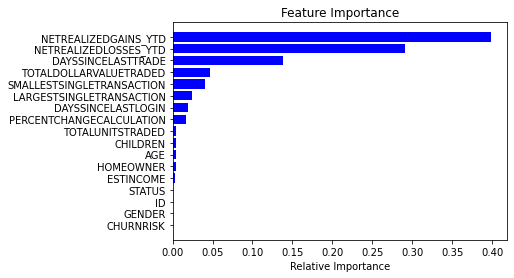

In [25]:
plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

Before we save the random forest classifier to repository, let us first evaluate the performance of a simple Naive Bayes classifier trained on the training dataset. 

In [26]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

stages_nb = stages

stages_nb[-2] = nb

pipeline_nb = Pipeline(stages = stages_nb)

# Build models
model_nb = pipeline_nb.fit(train)
results_nb = model_nb.transform(test)

print('Naive Bayes Model Precision = {:.2f}.'.format(results_nb.filter(results_nb.label == results_nb.prediction).count() / float(results_nb.count())))

Naive Bayes Model Precision = 0.67.


As you can see from the results above, Naive Bayes classifier does not perform well. Random forest classifier shows high F-measure upon evaluation and shows strong performance. Hence, we will save this model to the repository.

<a id="save_model"></a>
## 6. Save and deploy the model using Watson Machine Learning
[Top](#top)

The Watson Machine Learning client should be available on your IBM Cloud Pak for Data platform. 

<h3><font color="RED">ACTION: Obtain the URL, username and password for your IBM Cloud Pak for Data instance from your IBM Cloud Pak for Data administrator and provide the values in the code cell below.</font></h3>

In [27]:
from ibm_watson_machine_learning import APIClient

# get URL, username and password from your IBM Cloud Pak for Data administrator
wml_credentials = {
  "url": "https://X.X.X.X",
  "username": "*****",
  "password": "*****",
  "instance_id": "wml_local",
  "version" : "3.5"
}

client = APIClient(wml_credentials)
print(client.version)

1.0.44


### Set default space

In order to deploy a model, you would have to create different deployment spaces and deploy your models there. You can list all the spaces using the .list() function, or you can create new spaces by going to CP4D menu on top left corner --> analyze --> analytics deployments --> New Deployment Space. Once you know which space you want to deploy in, simply use the ID of the space as argument for .set.default_space() function below.

<h3><font color="RED">ACTION: Provide the name of your deployment space in the code cell below.</font></h3>

In [ ]:
#Insert the name of your deployment space here:
DEPLOYMENT_SPACE_NAME = 'Customer churn deployment space'

The deployment space ID will be looked up based on the name specified above. If you do not receive a space ID as an output to the next cell, verify that you have provided the correct deployment space name.

<h3><font color="RED">NOTE: Do not proceed until you have created a deployment space and this next cell runs successfully and returns the space_id.</font></h3>

In [29]:
# Be sure to update the name of the space with the one you want to use.
client.spaces.list()
all_spaces = client.spaces.get_details()['resources']
space_id = None
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["id"]
        print("\nDeployment Space ID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -------------------------------  ------------------------
ID                                    NAME                             CREATED
1d32c137-9593-4990-8066-c886b9137879  Customer churn deployment space  2020-12-03T16:04:46.009Z
------------------------------------  -------------------------------  ------------------------

Deployment Space ID:  1d32c137-9593-4990-8066-c886b9137879


<h3><font color="RED">ACTION: Set the ID for your Deployment space as the default_space in the method below:</font></h3>

In [30]:
# Now set the default space to the ID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
client.set.default_space('1d32c137-9593-4990-8066-c886b9137879')

'SUCCESS'

In [31]:
# Use this cell to do any cleanup of previously created models and deployments
#client.deployments.delete('<GUID of the deployment>')
#client.repository.delete('<ID of the model>')

client.deployments.list()
client.repository.list_models()

----  ----  -----  -------
GUID  NAME  STATE  CREATED
----  ----  -----  -------
--  ----  -------  ----
ID  NAME  CREATED  TYPE
--  ----  -------  ----


In [32]:
# Store our model
software_spec_uid=client.software_specifications.get_id_by_name('spark-mllib_2.4')
model_props = {
               client.repository.ModelMetaNames.NAME: "Trading Customer Churn Prediction Model",
               client.repository.ModelMetaNames.TYPE: 'mllib_2.4',
               client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
               client.repository.ModelMetaNames.INPUT_DATA_SCHEMA: {'id': '1', 'type': 'struct', 'fields': [
                   {'name': 'ID', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'GENDER', 'type': 'str', 'nullable': False, 'metadata': {}},
                   {'name': 'STATUS', 'type': 'str', 'nullable': False, 'metadata': {}}, 
                   {'name': 'CHILDREN', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'ESTINCOME', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'HOMEOWNER', 'type': 'str', 'nullable': False, 'metadata': {}},
                   {'name': 'AGE', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'TOTALDOLLARVALUETRADED', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'TOTALUNITSTRADED', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'LARGESTSINGLETRANSACTION', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'SMALLESTSINGLETRANSACTION', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'PERCENTCHANGECALCULATION', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'DAYSSINCELASTLOGIN', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'DAYSSINCELASTTRADE', 'type': 'double', 'nullable': False, 'metadata': {}}, 
                   {'name': 'NETREALIZEDGAINS_YTD', 'type': 'double', 'nullable': False, 'metadata': {}},
                   {'name': 'NETREALIZEDLOSSES_YTD', 'type': 'double', 'nullable': False, 'metadata': {}}
               ]}}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train)

In [33]:
# new list of models
client.repository.list_models()

# get UID of our just stored model
model_uid = client.repository.get_model_uid(published_model)
print("Model id: {}".format(model_uid))

------------------------------------  ---------------------------------------  ------------------------  ---------
ID                                    NAME                                     CREATED                   TYPE
03370d46-0691-45f8-9380-09f4cfe9f76f  Trading Customer Churn Prediction Model  2020-12-07T14:56:41.002Z  mllib_2.4
------------------------------------  ---------------------------------------  ------------------------  ---------
Model id: 03370d46-0691-45f8-9380-09f4cfe9f76f


In [34]:
meta_props = {
        client.deployments.ConfigurationMetaNames.NAME: "Trading Customer Churn Deployment",
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
created_deployment = client.deployments.create(artifact_uid=model_uid , meta_props=meta_props)

# new list of deployments
client.deployments.list()


# get UID of our new deployment
deployment_uid = client.deployments.get_uid(created_deployment)
print("Deployment id: {}".format(deployment_uid))



#######################################################################################

Synchronous deployment creation for uid: '03370d46-0691-45f8-9380-09f4cfe9f76f' started

#######################################################################################


initializing.........
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9e97a3bd-b6a1-4fa9-8371-2abb868714fa'
------------------------------------------------------------------------------------------------


------------------------------------  ---------------------------------  -----  ------------------------
GUID                                  NAME                               STATE  CREATED
9e97a3bd-b6a1-4fa9-8371-2abb868714fa  Trading Customer Churn Deployment  ready  2020-12-07T14:56:46.503Z
------------------------------------  ---------------------------------  -----  ------------------------
Depl

In [35]:
print(created_deployment)

{'entity': {'asset': {'id': '03370d46-0691-45f8-9380-09f4cfe9f76f'}, 'custom': {}, 'deployed_asset_type': 'model', 'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1}, 'name': 'Trading Customer Churn Deployment', 'online': {}, 'space_id': '1d32c137-9593-4990-8066-c886b9137879', 'status': {'online_url': {'url': 'https://X.X.X.X/ml/v4/deployments/9e97a3bd-b6a1-4fa9-8371-2abb868714fa/predictions'}, 'state': 'ready'}}, 'metadata': {'created_at': '2020-12-07T14:56:46.503Z', 'id': '9e97a3bd-b6a1-4fa9-8371-2abb868714fa', 'modified_at': '2020-12-07T14:56:46.503Z', 'name': 'Trading Customer Churn Deployment', 'owner': '1000331002', 'space_id': '1d32c137-9593-4990-8066-c886b9137879'}}


In [36]:
# get the scoring endpoint (deployment href) for the deployed WML model
deployment_href = client.deployments.get_href(created_deployment)
print(deployment_href)

/ml/v4/deployments/9e97a3bd-b6a1-4fa9-8371-2abb868714fa


In [37]:
# get the deployment id for the deployed WML model
deployment_id = client.deployments.get_uid(created_deployment)
print(deployment_id)

9e97a3bd-b6a1-4fa9-8371-2abb868714fa


In [38]:
# test the model using an array of values
import json
values = [4,"F","M",2,52004,"N",60,5030,23,1257,125,3,1,1,1000,0]
fields = ["ID", "GENDER", "STATUS","CHILDREN","ESTINCOME","HOMEOWNER","AGE","TOTALDOLLARVALUETRADED","TOTALUNITSTRADED","LARGESTSINGLETRANSACTION","SMALLESTSINGLETRANSACTION","PERCENTCHANGECALCULATION","DAYSSINCELASTLOGIN","DAYSSINCELASTTRADE","NETREALIZEDGAINS_YTD","NETREALIZEDLOSSES_YTD"]
scoring_payload = {client.deployments.ScoringMetaNames.INPUT_DATA: [{"fields": fields, "values": [values]}]}
print(json.dumps(scoring_payload, indent=2))

{
  "input_data": [
    {
      "fields": [
        "ID",
        "GENDER",
        "STATUS",
        "CHILDREN",
        "ESTINCOME",
        "HOMEOWNER",
        "AGE",
        "TOTALDOLLARVALUETRADED",
        "TOTALUNITSTRADED",
        "LARGESTSINGLETRANSACTION",
        "SMALLESTSINGLETRANSACTION",
        "PERCENTCHANGECALCULATION",
        "DAYSSINCELASTLOGIN",
        "DAYSSINCELASTTRADE",
        "NETREALIZEDGAINS_YTD",
        "NETREALIZEDLOSSES_YTD"
      ],
      "values": [
        [
          4,
          "F",
          "M",
          2,
          52004,
          "N",
          60,
          5030,
          23,
          1257,
          125,
          3,
          1,
          1,
          1000,
          0
        ]
      ]
    }
  ]
}


In [39]:
# score the model by calling the WML service with the user provided data
predictions = client.deployments.score(deployment_id, scoring_payload)
print(predictions)

{'predictions': [{'fields': ['ID', 'GENDER', 'STATUS', 'CHILDREN', 'ESTINCOME', 'HOMEOWNER', 'AGE', 'TOTALDOLLARVALUETRADED', 'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION', 'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION', 'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD', 'NETREALIZEDLOSSES_YTD', 'GENDERIndex', 'GENDERclassVec', 'STATUSIndex', 'STATUSclassVec', 'HOMEOWNERIndex', 'HOMEOWNERclassVec', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'], 'values': [[4, 'F', 'M', 2, 52004, 'N', 60, 5030, 23, 1257, 125, 3, 1, 1, 1000, 0, 0.0, [1, [0], [1.0]], 0.0, [2, [0], [1.0]], 0.0, [1, [0], [1.0]], [1.0, 1.0, 0.0, 1.0, 4.0, 2.0, 52004.0, 60.0, 5030.0, 23.0, 1257.0, 125.0, 3.0, 1.0, 1.0, 1000.0, 0.0], [1.0964135427688215, 12.933118445695461, 5.970468011535719], [0.05482067713844107, 0.646655922284773, 0.2985234005767859], 1.0, 'Low']]}]}


### Save the test data as files so that they can be added as assets to your IBM Cloud Pak for Data project

In [40]:
# Write the test data without label to a .csv so that we can later use it for batch scoring
write_score_CSV=test.toPandas().drop(['CHURNRISK'], axis=1)
write_score_CSV.to_csv('/project_data/data_asset/TradingCustomerSparkMLBatchScore.csv', sep=',', index=False)

In [41]:
# Write the test data to a .csv so that we can later use it for evaluation
write_eval_CSV=test.toPandas()
write_eval_CSV.to_csv('/project_data/data_asset/TradingCustomerSparkMLEval.csv', sep=',', index=False)

<p><font size=-1 color=gray>
&copy; Copyright 2018 IBM Corp. All Rights Reserved.
<p>
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the
License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
express or implied. See the License for the specific language governing permissions and
limitations under the License.
</font></p>